# Infering a Bayesian Mixture
## <font color='red'> Assumption: The data gives an indication of the underlying distributions. Number of clusters is known. </font>
### <font color='red'> After convergence, the mean and covariance matrices are drawn from a distribution for each cluster. </font>

## Import modules

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Load data

In [2]:
npzfile = np.load('GaussianMixture.npz')
n_dim = len(npzfile.files) - 1
print(n_dim)
print(npzfile.files)

2
['x_sample', 'y_sample', 'mixing_idx']


## Plot data
The information which component generated which sample is deliberately not plotted.

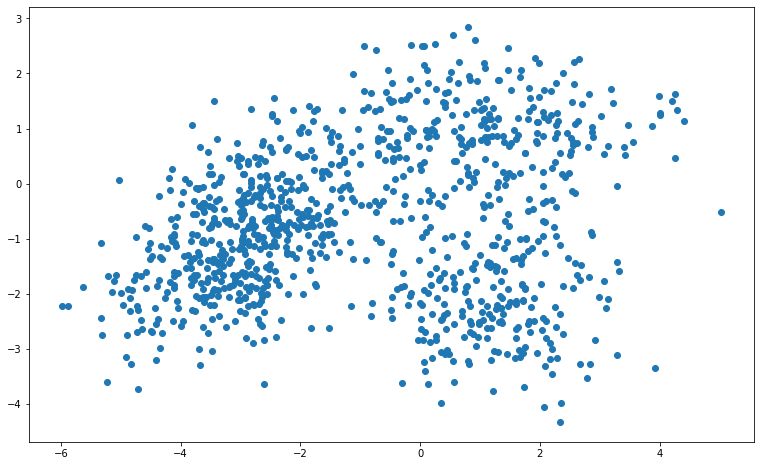

In [3]:
x_sample = npzfile['x_sample']
y_sample = npzfile['y_sample']
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample)
plt.show()

## Bayesian Mixture Model
For illustration, *sklearn.mixture.BayesianGaussianMixture* is not used, but a new function is implemented. For explanation and formulae please see the slides.

In [4]:
def InferBayesianMixture(data,n_comp,alpha0,mean0,lambda0,scale0,df0,n_iter = 100):
    """ Input:
    data:     data,
    n_comp:   number of clusters
    alpha0:   prior concentration parameter,
    mean0:    prior location vector,
    lambda0:  prior mean fraction,
    scale:    prior scale matrix,
    df:       prior degrees of freedom,
    n_iter:   number of iterations
    Output:
    idx:      index vector which process generated the sample,
    p:        array of mixing coefficients,
    means:    array of the means of all processes,
    covs:     array of the covariance matrices of all processes."""
    size = len(data)
    n_dim = data.shape[1]
    # Start with uniform random cluster assignments.
    idx = np.random.choice(n_components,size, replace=True)
    # Allocate space for the mixing coefficients.
    p = np.zeros((size,n_components))
    # For each component allocate space to store :
    # its size:
    comp_size = np.zeros((1,n_components))
    # its mean location vector
    comp_mean = np.zeros((n_dim,n_comp))
    # its mean fraction
    comp_lambda = np.zeros((1,n_components))
    # its scale matrix
    comp_scale = np.zeros((n_dim,n_dim,n_comp))
    # its degrees of freedom
    comp_df = np.zeros((1,n_components))
    # a draw from the posterior normal, inverse Wishart distribution.
    covs = np.zeros((n_dim,n_dim,n_comp))
    means = np.zeros((n_dim,n_comp))
    # For each component initialize the hyperparameters for the initial random assignments 
    # and draw a mean and covariance from that posterior normal, inverse Wishart distribution.
    for k in range(n_comp):
        # Hyperparameters
        comp_data = data[idx == k,:]
        comp_size[:,k] = len(comp_data)
        comp_lambda[:,k] = lambda0 + len(comp_data)
        sample_mean = np.mean(comp_data,0,keepdims=True)
        sample_cov = np.cov(comp_data,rowvar=False)
        comp_mean[:,k] = (lambda0 * mean0 + comp_size.item(k)*sample_mean) / comp_lambda.item(k)
        comp_scale[:,:,k] = scale0 + comp_size.item(k) * sample_cov + \
          lambda0 * comp_size.item(k) * (sample_mean - mean0).T @ (sample_mean - mean0) / comp_lambda.item(k)
        comp_df[:,k] = df0 + comp_size.item(k)
        # Draws
        covs[:,:,k] = ss.invwishart.rvs(df = comp_df.item(k), scale = comp_scale[:,:,k])
        means[:,k]=np.random.multivariate_normal(mean = comp_mean[:,k], cov = covs[:,:,k]/comp_lambda.item(k))
        
    for i in range(n_iter):
        # Consider the data in a random order.
        r = list(range(size))
        np.random.shuffle(r)
        for n in r:
            v = data[n,:]
            l = idx[n]
            # Remove this sample from the cluster it was assigned to.
            priorlambda = comp_lambda.item(l)-1
            temp = (v-comp_mean[:,l]).reshape(1,2)
            comp_scale[:,:,l] = comp_scale[:,:,l] - \
              comp_lambda.item(l)/priorlambda * temp.T @ temp
            comp_mean[:,l] = (comp_lambda.item(l)*comp_mean[:,l]-v)/priorlambda
            comp_df[:,l] = comp_df.item(l) -1
            comp_lambda[:,l] = priorlambda
            # Draw new mean and covariance.
            covs[:,:,l] = ss.invwishart.rvs(df = comp_df.item(l), scale = comp_scale[:,:,l])
            means[:,l]=np.random.multivariate_normal(mean = comp_mean[:,l], cov = covs[:,:,l]/comp_lambda.item(l))
            comp_size[:,l] = comp_size.item(l) -1
            
            # Calculate cluster assignment probabilities.
            for k in range(n_comp):
                p[n,k] = (comp_size.item(k) + alpha0/n_comp)/(n_comp-1+alpha0) * \
                  ss.multivariate_normal.pdf(v,means[:,k],covs[:,:,k])
            p[n,:] = p[n,:]/sum(p[n,:])
            # Sample new indicator variable.
            l = np.random.choice(n_comp,p=p[n,:])
            idx[n] = l
            
            # Add this sample to this cluster.
            postlambda = comp_lambda.item(l)+1
            temp = (v-comp_mean[:,l]).reshape(1,2)
            comp_scale[:,:,l] = comp_scale[:,:,l] + \
              comp_lambda.item(l)/postlambda * temp.T @ temp
            comp_mean[:,l] = (comp_lambda.item(l)*comp_mean[:,l]+v)/postlambda
            comp_df[:,l] = comp_df.item(l) +1
            comp_lambda[:,l] = postlambda
            # Draw new mean and covariance.
            covs[:,:,l] = ss.invwishart.rvs(df = comp_df.item(l), scale = comp_scale[:,:,l])
            means[:,l]=np.random.multivariate_normal(mean = comp_mean[:,l], cov = covs[:,:,l]/comp_lambda.item(l))
            comp_size[:,l] = comp_size.item(l) +1
    weights = comp_size/size
    return idx, p, weights, means, covs

### Initialize priors
The priors are chosen to be uninformative. The *location vector* $\mathbf{m}$ is initialized to the mean of the all data samples. The *mean fraction* $\lambda$ is intialized to $1$ supporting the assumption that the clusters overlay. The *inverse scale matrix* $\boldsymbol{\Psi}$ is initialized to the average squared distance from mean in each dimension times the identity. The degrees of freedom $\nu$ is set to the number of dimensions. <font color='red'> This is most uninformative. </font>

In [5]:
data = np.stack((x_sample, y_sample)).T
mean0 = np.mean(data,0,keepdims=True)
lambda0 = 1
scale0 = np.sum(np.square(data - mean0))/len(data) * np.identity(2)
df0 = n_dim
n_iter = 10

### Training with 3 components
The hyperparameter $\alpha$ is set to the number of components. This means all vectors of mixing coefficients are equally likely. 

In [6]:
n_components = 3
alpha0 = n_components
idx, p, weights, means, covs = InferBayesianMixture(data,n_components,alpha0,mean0,lambda0,scale0,df0,n_iter)

#### Results
The data was generated mixing three normal distributions, 
Here the mixture is composed of three normal distributions, 
\begin{equation}
\mathcal{N}\left( \left( 1 \atop 1 \right), \left( 2 \atop 0 \right. \left. 0 \atop 0.5 \right) \right), \mathcal{N}\left( \left( {-3} \atop {-1} \right), \left( 1 \atop 0.5 \right. \left. 0.5 \atop 1 \right) \right), \mathcal{N}\left( \left( 1 \atop {-2} \right), \left( 1 \atop 0 \right. \left. 0 \atop 1 \right) \right).
\end{equation}
with mixing coefficients 0.25, 0.5 and 0.25. 

In [7]:
print('Estimated mixing coefficients:' , weights) 
for i in range(n_components):
    print('Component', i+1)
    print('Estimated mean:', means[:,i])
    print('Estimated covariance:', covs[:,:,i], '\n')

Estimated mixing coefficients: [[0.274 0.511 0.215]]
Component 1
Estimated mean: [1.03513062 0.86013846]
Estimated covariance: [[2.020282   0.08557456]
 [0.08557456 0.89788047]] 

Component 2
Estimated mean: [-2.93476357 -1.03029658]
Estimated covariance: [[1.21123691 0.6133778 ]
 [0.6133778  1.16261468]] 

Component 3
Estimated mean: [ 1.31359899 -2.15859118]
Estimated covariance: [[ 1.10424861 -0.00476976]
 [-0.00476976  0.63251914]] 



#### Plot data 
First coloured by sampled cluster assignments. Quite a few assignments seem incorrect. More iterations could resolve this, but only if there is no uncertainty in the data itself (see below).

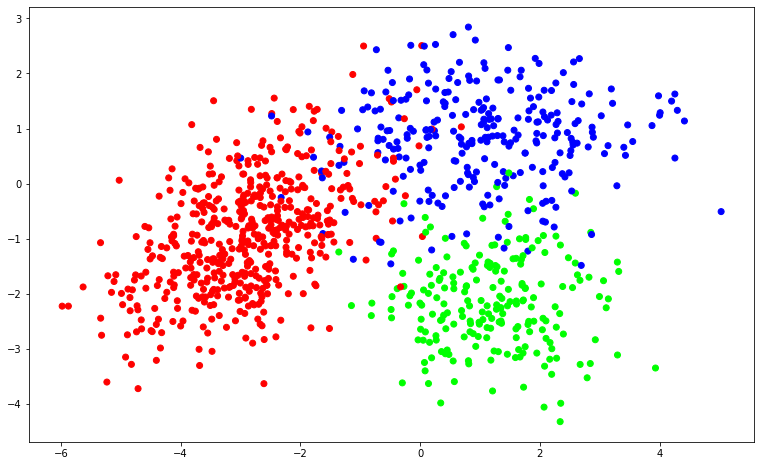

In [8]:
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample, c = idx, cmap = plt.cm.brg)
plt.show()

Secondly, each sample is given a colour mixed from red, green and blue according to the estimated posterior assignment probabilities, also known as *responsibilities*. The regions where we have a mix of colours are those where the responsibilities are *not* clearly favouring one cluster. This also explains the incorrect assignments in the previous plot.

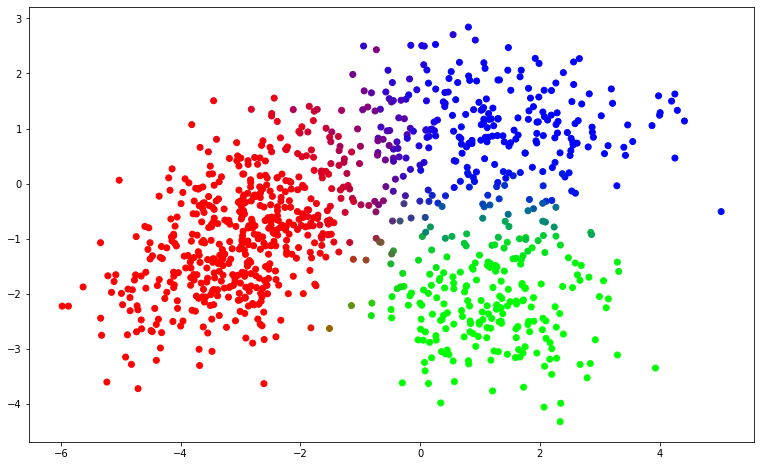

In [9]:
fig = plt.figure(figsize=(13,8))
# This transformation is for the sole purpose of aligning the colours between the two plots.
c = p @ np.array([[0,0,1],[1,0,0],[0,1,0]])
plt.scatter(x_sample, y_sample, c = c)
plt.show()

### Training with 2 Components

In [10]:
n_components = 2
alpha0 = n_components
idx, p, weights, means, covs = InferBayesianMixture(data,n_components,alpha0,mean0,lambda0,scale0,df0,n_iter)

#### Results

In [11]:
print('Estimated mixing coefficients:' , weights) 
for i in range(n_components):
    print('Component', i+1)
    print('Estimated mean:', means[:,i])
    print('Estimated covariance:', covs[:,:,i], '\n')

Estimated mixing coefficients: [[0.322 0.678]]
Component 1
Estimated mean: [ 0.96657227 -1.53255943]
Estimated covariance: [[2.89362119 0.05006926]
 [0.05006926 1.62151818]] 

Component 2
Estimated mean: [-1.75536798 -0.28764425]
Estimated covariance: [[4.93313214 2.21935759]
 [2.21935759 1.79507737]] 



#### Plot data 
First coloured by sampled cluster assignments. 

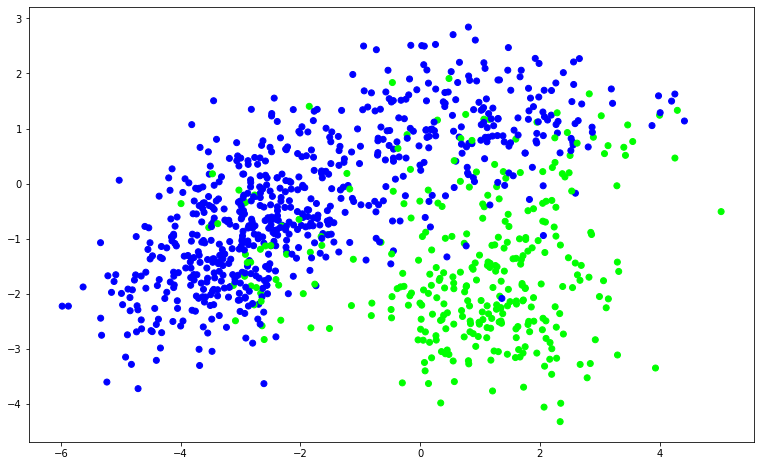

In [12]:
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample, c = abs(idx-1), cmap = plt.cm.brg)
plt.show()

Secondly, each sample is given a colour mixed from red, green and blue according to the estimated posterior assignment probabilities, also known as responsibilities. 

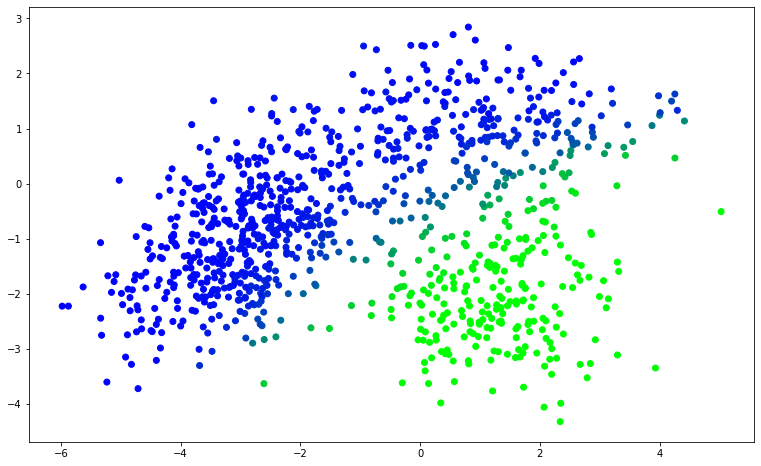

In [13]:
c = np.concatenate((np.zeros((p.shape[0],1)),p),1 )
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample, c = c)
plt.show()

## Exploration
Run the Bayesian mixture inference several times with the same number of iterations and then increasing and decreasing the number of iterations. You should find that <font color='red'>sometimes the estimates are quite good even with a low number of iterations while at other times even a high number of iterations can give poor results. This is due to the probabilistic nature of the algorithm, since the mean, and covariance of each cluster and the cluster assignment of each data point is sampled.</font>

### <font color='red'> Needed: More flexibility with regards to number of clusters. </font>
### <font color='red'> => Dirchlet Process method aka Chinese restaurant process.</font>